In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here
from itertools import chain
from skimage import io
from IPython.display import clear_output

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the following EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

## Import Data

Also, **describe your findings and how will you set up the model training based on the findings.**

In [2]:
## Below is some helper code to read data for you.
## Load NIH data
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

Image Index Finding Labels  Follow-up #  Patient ID Patient Age  \
1149  00006035_003.png     No Finding            3        6035        038Y   
611   00003129_004.png     No Finding            4        3129        061Y   
5164  00027565_000.png   Infiltration            0       27565        052Y   

     Patient Gender View Position  OriginalImageWidth  OriginalImageHeight  \
1149              M            PA                2500                 2048   
611               M            PA                2500                 2048   
5164              F            PA                2992                 2991   

      OriginalImagePixelSpacing_x  OriginalImagePixelSpacing_y  
1149                        0.171                        0.171  
611                         0.168                        0.168  
5164                        0.143                        0.143

## Review Dataframe & Perform Data Cleaning

In [3]:
all_xray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
dtypes: float64(3), int64(5), object(4)
memory usage: 10.3+ MB


In [4]:
all_xray_df.describe()

Follow-up #     Patient ID    Patient Age  OriginalImage[Width  \
count  112120.000000  112120.000000  112120.000000        112120.000000   
mean        8.573751   14346.381743      46.901463          2646.078844   
std        15.406320    8403.876972      16.839923           341.246429   
min         0.000000       1.000000       1.000000          1143.000000   
25%         0.000000    7310.750000      35.000000          2500.000000   
50%         3.000000   13993.000000      49.000000          2518.000000   
75%        10.000000   20673.000000      59.000000          2992.000000   
max       183.000000   30805.000000     414.000000          3827.000000   

             Height]  OriginalImagePixelSpacing[x             y]  Unnamed: 11  
count  112120.000000                112120.000000  112120.000000          0.0  
mean     2486.438842                     0.155649       0.155649          NaN  
std       401.268227                     0.016174       0.016174          NaN  
min       966.000000                     0.115000       0.115000          NaN  
25%      2048.000000                     0.143000       0.143000          NaN  
50%      2544.000000                     0.143000       0.143000          NaN  
75%      2991.000000                     0.168000       0.168000          NaN  
max      4715.000000                     0.198800       0.198800          NaN

### Findings: 
* Column "Unnamed: 11" contains all null data.  

### Remove "Unnamed: 11" column

In [5]:
all_xray_df.columns.str.contains('^Unnamed')

array([False, False, False, False, False, False, False, False, False,
       False, False,  True])

In [6]:
all_xray_df_0 = all_xray_df.loc[:, ~all_xray_df.columns.str.contains('^Unnamed')]
all_xray_df_0.sample(5)

Image Index Finding Labels  Follow-up #  Patient ID  Patient Age  \
14880   00003882_004.png     No Finding            4        3882           51   
57987   00014355_012.png       Effusion           12       14355           53   
26583   00006966_003.png     No Finding            3        6966           47   
102669  00027368_006.png     No Finding            6       27368           20   
72777   00017941_002.png     No Finding            2       17941           34   

       Patient Gender View Position  OriginalImage[Width  Height]  \
14880               M            PA                 2500     2048   
57987               M            PA                 2742     2991   
26583               M            PA                 2500     2048   
102669              F            AP                 3056     2544   
72777               M            AP                 2500     2048   

        OriginalImagePixelSpacing[x     y]  
14880                         0.171  0.171  
57987                         0.143  0.143  
26583                         0.168  0.168  
102669                        0.139  0.139  
72777                         0.168  0.168

### Split "Finding Labels" column to create some extra columns with binary indicators of certain diseases

In [7]:
all_xray_labels = np.unique(list(chain(*all_xray_df_0['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_xray_labels = [x for x in all_xray_labels if len(x)>0]
print("Number of labels: {}\nLabels: {}".format(len(all_xray_labels),", ".join(all_xray_labels)))
for c_label in all_xray_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df_0[c_label] = all_xray_df_0['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

all_xray_df_0.sample(5)        

Number of labels: 15
Labels: Atelectasis, Cardiomegaly, Consolidation, Edema, Effusion, Emphysema, Fibrosis, Hernia, Infiltration, Mass, No Finding, Nodule, Pleural_Thickening, Pneumonia, Pneumothorax


Image Index         Finding Labels  Follow-up #  Patient ID  \
61528  00015190_002.png             No Finding            2       15190   
54110  00013616_050.png  Cardiomegaly|Effusion           50       13616   
6213   00001684_014.png             No Finding           14        1684   
78044  00019164_000.png             No Finding            0       19164   
54515  00013670_022.png          Consolidation           22       13670   

       Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
61528           51              M            PA                 2992     2991   
54110           63              M            AP                 2500     2048   
6213            58              M            AP                 2500     2048   
78044           53              F            PA                 2021     2021   
54515           56              M            AP                 2500     2048   

       OriginalImagePixelSpacing[x  ...  Emphysema  Fibrosis  Hernia  \
61528                     0.143000  ...        0.0       0.0     0.0   
54110                     0.168000  ...        0.0       0.0     0.0   
6213                      0.168000  ...        0.0       0.0     0.0   
78044                     0.194311  ...        0.0       0.0     0.0   
54515                     0.168000  ...        0.0       0.0     0.0   

       Infiltration  Mass  No Finding  Nodule  Pleural_Thickening  Pneumonia  \
61528           0.0   0.0         1.0     0.0                 0.0        0.0   
54110           0.0   0.0         0.0     0.0                 0.0        0.0   
6213            0.0   0.0         1.0     0.0                 0.0        0.0   
78044           0.0   0.0         1.0     0.0                 0.0        0.0   
54515           0.0   0.0         0.0     0.0                 0.0        0.0   

       Pneumothorax  
61528           0.0  
54110           0.0  
6213            0.0  
78044           0.0  
54515           0.0  

[5 rows x 26 columns]

## Perform EDA on patient demographic data: gender, age, view position

### (1) Age

### Remove rows with the patient age > 100

In [8]:
all_xray_df_1 = all_xray_df_0.loc[all_xray_df_0['Patient Age'] < 100]

### Visualize age distribution 

(array([ 1803.,  5021., 12798., 14580., 18664., 26481., 20790.,  9793.,
         1917.,   257.]),
 array([ 1. , 10.4, 19.8, 29.2, 38.6, 48. , 57.4, 66.8, 76.2, 85.6, 95. ]),
 <a list of 10 Patch objects>)

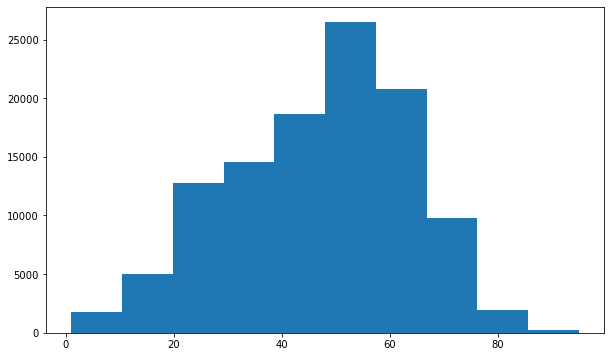

In [10]:
# visualize general age distribution among all patients 
plt.figure(figsize=(10,6))
plt.hist(all_xray_df_1['Patient Age'])

(array([ 41.,  85., 174., 203., 196., 243., 266., 175.,  39.,   8.]),
 array([ 2. , 10.8, 19.6, 28.4, 37.2, 46. , 54.8, 63.6, 72.4, 81.2, 90. ]),
 <a list of 10 Patch objects>)

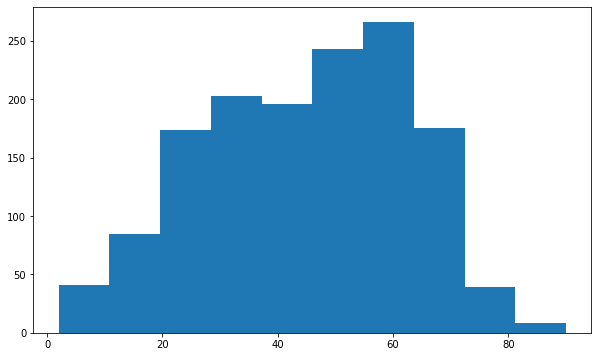

In [11]:
# visualize age distribution among patients with Pneumonia  
plt.figure(figsize=(10,6))
plt.hist(all_xray_df_1[all_xray_df_1.Pneumonia==1]['Patient Age'])

### Findings: 
* Most of our Pneumonia patients are in the age from 20 to 70, with the peak at around 60

### (2) Gender

### Visualize gender distribution 

In [13]:
colors_list = ['green','orange']

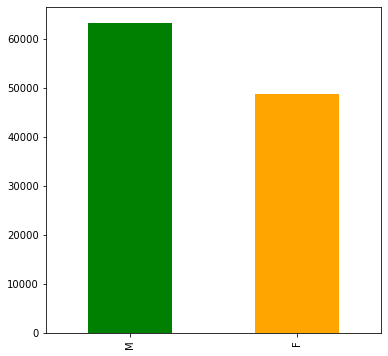

In [16]:
# visualize general gender distribution among all patients 
plt.figure(figsize=(6,6))
all_xray_df_1['Patient Gender'].value_counts().plot(kind='bar', color=colors_list)

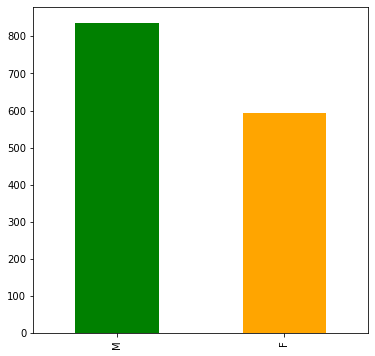

In [18]:
# visualize gender distribution among patients with Pneumonia  
plt.figure(figsize=(6,6))
all_xray_df_1[all_xray_df_1.Pneumonia==1]['Patient Gender'].value_counts().plot(kind='bar', color=colors_list)

### Findings: 
* Gender distribution is skewed towards "M" among the whole patients as well as those with Pneumonia  

### (3) View Position

### Visualize view position distribution 

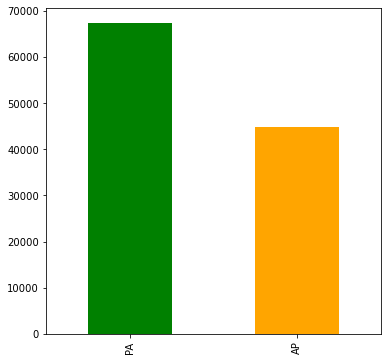

In [19]:
# visualize general view position distribution among all patients 
plt.figure(figsize=(6,6))
all_xray_df_1['View Position'].value_counts().plot(kind='bar', color=colors_list)

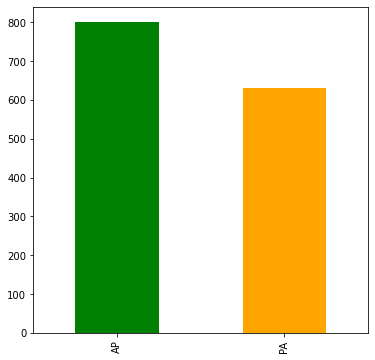

In [20]:
# visualize view position distribution among patients with Pneumonia  
plt.figure(figsize=(6,6))
all_xray_df_1[all_xray_df_1.Pneumonia==1]['View Position'].value_counts().plot(kind='bar', color=colors_list)

### Findings: 
* View position distribution is skewed towards "AP" among the whole patients as well as those with Pneumonia  

## Perform EDA on diseases distribution

### Visualize diseases distribution

[Text(0, 0.5, 'Number of Images with Each Label')]

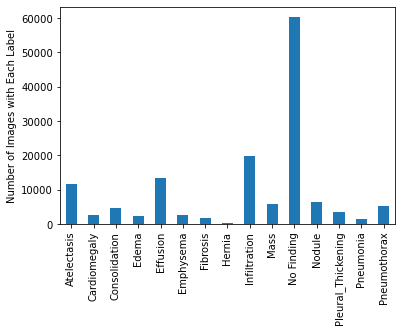

In [22]:
ax = all_xray_df_1[all_xray_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Each Label')

### Review general diseases distribution information

In [25]:
# number of patients for each diseases
all_xray_df_1[all_xray_labels].sum()

Atelectasis           11558.0
Cardiomegaly           2776.0
Consolidation          4667.0
Edema                  2302.0
Effusion              13316.0
Emphysema              2516.0
Fibrosis               1686.0
Hernia                  227.0
Infiltration          19891.0
Mass                   5779.0
No Finding            60353.0
Nodule                 6331.0
Pleural_Thickening     3384.0
Pneumonia              1430.0
Pneumothorax           5301.0
dtype: float64

In [26]:
# percentage of each diseases in the whole dataframe
all_xray_df_1[all_xray_labels].sum()/len(all_xray_df_1)*100

Atelectasis           10.310069
Cardiomegaly           2.476272
Consolidation          4.163099
Edema                  2.053450
Effusion              11.878256
Emphysema              2.244345
Fibrosis               1.503961
Hernia                 0.202491
Infiltration          17.743345
Mass                   5.155035
No Finding            53.836616
Nodule                 5.647435
Pleural_Thickening     3.018626
Pneumonia              1.275601
Pneumothorax           4.728645
dtype: float64

### Findings: 
*  'No Finding' is the most common occurrence: there is no finding in the image in 53.8% of this dataset. Beyond that, 'Infiltration' is the most common disease-related label (17.7%), followed by 'Effusion' (11.9%) and 'Atelectasis' (10.3%).   

## Review Pneumonia information

In [28]:
# number of pneumonia cases
num_pneumonia = all_xray_df_1['Pneumonia'].sum()
print("Number of Pneumonia cases: {}".format(num_pneumonia))
print("Percent of Pneumonia cases: {}".format(num_pneumonia/len(all_xray_df_1)))

# number of non-pneumonia cases and has other disease
num_non_pneumonia = len(all_xray_df_1.loc[(all_xray_df_1['Pneumonia']==0) & (all_xray_df_1['No Finding']!=0)])
print("Number of non-Pneumonia cases: {}".format(num_non_pneumonia))
print("Percent of non-Pneumonia cases: {}".format(num_non_pneumonia/len(all_xray_df_1)))

Number of Pneumonia cases: 1430.0
Percent of Pneumonia cases: 0.012756012274316705
Number of non-Pneumonia cases: 60353
Percent of non-Pneumonia cases: 0.538366159994291


### Findings: 
* The number of Pneumonia is 1430, accounting for only 1.28% of our dataframe. 
* The number of patients who don't have Pneumonia but other diseases is 60353, accounting for 53.84%.

## Review the 30 most common diseases co-occurrences

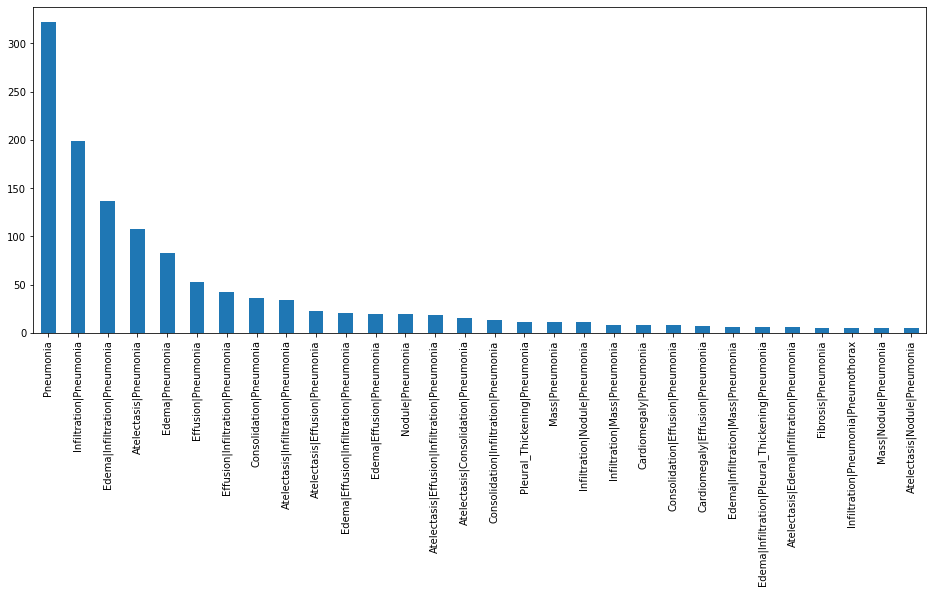

In [29]:
plt.figure(figsize=(16,6))
all_xray_df_1[all_xray_df_1.Pneumonia==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')

## Review the number of diseases per person

Number of Diseases
0.0    60353
1.0    30959
2.0    14302
3.0     4856
4.0     1247
5.0      301
6.0       67
7.0       16
8.0        1
9.0        2
Name: Number of Diseases, dtype: int64


[Text(0, 0.5, 'Number of Patients')]

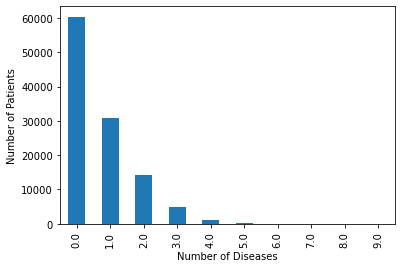

In [30]:
number_of_diseases_per_person = all_xray_df_1.iloc[:,11:].sum(axis=1) - all_xray_df_1['No Finding']
df = pd.DataFrame(number_of_diseases_per_person, columns=['Number of Diseases'])

group_number = df.groupby("Number of Diseases")["Number of Diseases"].count()
print(group_number)

ax = group_number.plot(kind = 'bar')
ax.set(ylabel = 'Number of Patients')

### Findings: 
*   Most of the patients does not have any diseases (i.e., "No Finding"). Beyond that, most of the patients have 1 or 2 kinds of diseases.

## Pixel level assessment

In [31]:
# visualize some images
images = []
for i, img_id in enumerate(sample_df['Image Index']):
    clear_output(wait=True)
    path = glob(os.path.join("/data","images*","*",img_id))[0]
    print("Loaded {}/{}".format(i+1, len(sample_df)))
    img = io.imread(path)
    images.append(img)

Loaded 5606/5606


In [32]:
# define a function to create a visualization panel for every 100 images 
def sample_stack(images, rows=7, cols=7, start_with=0, show_every=100):
    fig,ax = plt.subplots(rows,cols,figsize=[15,15])
    for i in range(rows*cols):
        ind = start_with + i*show_every
        ax[int(i/rows),int(i % rows)].set_title('Image %d' % ind)
        ax[int(i/rows),int(i % rows)].imshow(images[ind],cmap='gray')
        ax[int(i/rows),int(i % rows)].axis('off')
    plt.show()

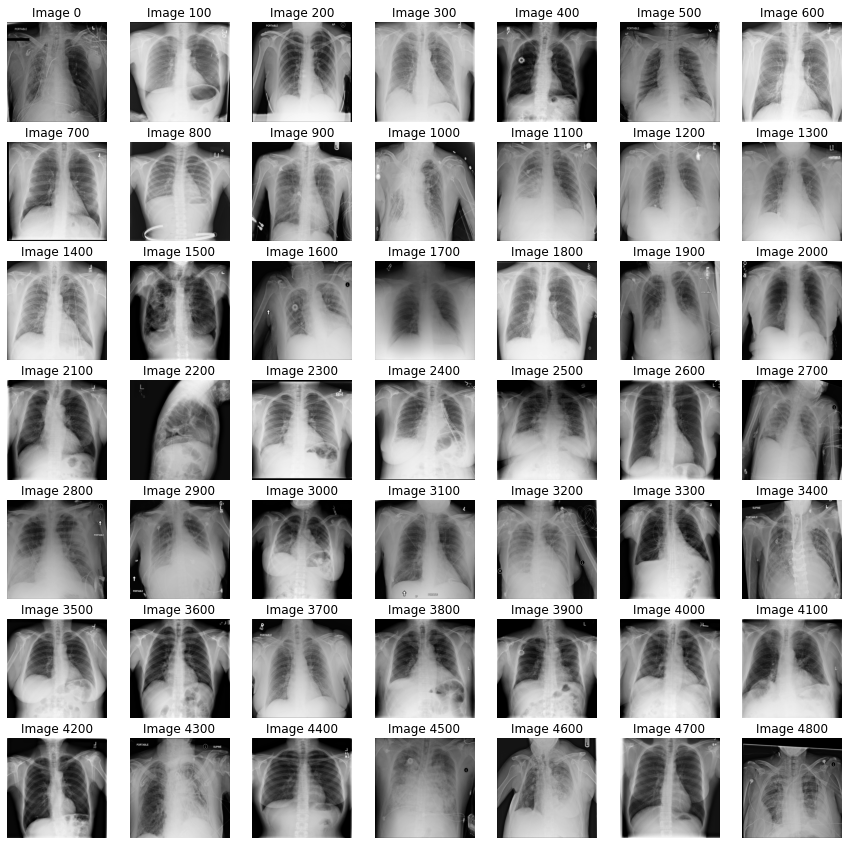

In [33]:
sample_stack(images)

In [35]:
intensity_images = []
for i, image in enumerate(images):
    clear_output(wait=True)
    intensity_images.append(np.mean(image))
    print("Done {}/{}".format(i, len(images)))
intensity_images = np.array(intensity_images)

Done 5605/5606


(array([ 4.,  8., 16., 13., 10.,  4.,  0.,  3.,  3.,  1.]),
 array([ 88.1964426 ,  98.5581321 , 108.9198216 , 119.28151109,
        129.64320059, 140.00489008, 150.36657958, 160.72826908,
        171.08995857, 181.45164807, 191.81333756]),
 <a list of 10 Patch objects>)

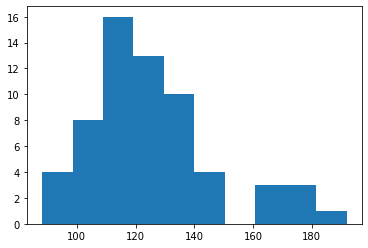

In [39]:
pneumonia_intensity = intensity_images[sample_df[sample_df["Finding Labels"].str.contains("Pneumonia")].index]
plt.hist(pneumonia_intensity)

(array([  3.,   6.,  14.,  67., 341., 272., 143.,  91.,  23.,   7.]),
 array([ 41.29449272,  56.17974558,  71.06499844,  85.95025129,
        100.83550415, 115.72075701, 130.60600986, 145.49126272,
        160.37651558, 175.26176844, 190.14702129]),
 <a list of 10 Patch objects>)

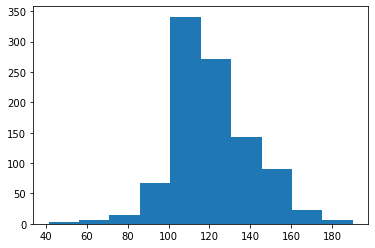

In [38]:
infiltration_intensity = intensity_images[sample_df[sample_df["Finding Labels"].str.contains("Infiltration")].index]
plt.hist(infiltration_intensity)

(array([  2.,   1.,  12.,  72., 227., 159.,  75.,  67.,  23.,   6.]),
 array([ 44.95568371,  59.80278091,  74.64987812,  89.49697533,
        104.34407253, 119.19116974, 134.03826694, 148.88536415,
        163.73246136, 178.57955856, 193.42665577]),
 <a list of 10 Patch objects>)

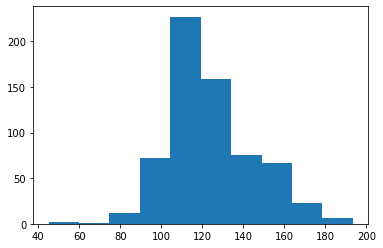

In [41]:
effusion_intensity = intensity_images[sample_df[sample_df["Finding Labels"].str.contains("Effusion")].index]
plt.hist(effusion_intensity)

### Findings: 
* The distribution of the pixel intesity values of Pneumonia, Infiltration, and Effusion patients, generally ranges between 100 and 140-160, with a peak around 110-120.

(array([   9.,   21.,   88.,  715., 2131., 1255.,  702.,  575.,  102.,
           8.]),
 array([ 37.45602131,  54.76187196,  72.06772261,  89.37357326,
        106.6794239 , 123.98527455, 141.2911252 , 158.59697585,
        175.9028265 , 193.20867715, 210.5145278 ]),
 <a list of 10 Patch objects>)

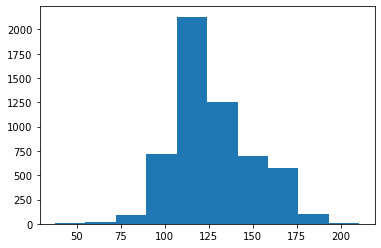

In [42]:
plt.hist(intensity_images)

### Findings: 
* The distribution of the pixel intesity values of all the images ranges between 100 and 140-160, with a peak around 110.

## Conclusions

From the above EDA, we could proceed to build our model to train based on the following properties of a patient:

- age, gender, view position
- intensity value of each image

In addition, some pre-processing of our images have to be performed including:
- to remove some of unnecessary columns
- to balance the number of non-pneumonia and pneumonia cases
- to normalize the images